<a href="https://colab.research.google.com/github/Louizaait/TFT/blob/main/solar_power_forecasting_using_GAN_GRU_MEO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
pip install mealpy pyswarm pysolar pvlib

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import plotly.graph_objects as go
import joblib

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential,load_model
from keras import layers
from keras.layers import GRU,Dense, Flatten

from pysolar.solar import get_altitude, get_azimuth
import pandas as pd
import pytz
import pvlib
from mealpy.physics_based import EO


In [ ]:
!wget https://zenodo.org/record/6906504/files/filtered_pv_power_measurements_ac.csv?download=1 -O filtered_ac.csv
#!wget https://zenodo.org/record/6906504/files/filtered_pv_power_measurements_sc.csv?download=1 -O filtered_sc.csv

--2023-10-03 13:18:00--  https://zenodo.org/record/6906504/files/filtered_pv_power_measurements_ac.csv?download=1
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2985408767 (2.8G) [text/plain]
Saving to: ‘filtered_ac.csv’

filtered_ac.csv     100%[===================>]   2.78G  6.55MB/s    in 42m 21s 

2023-10-03 14:00:23 (1.12 MB/s) - ‘filtered_ac.csv’ saved [2985408767/2985408767]



In [ ]:
#read a csv file
df = pd.read_csv('filtered_ac.csv')
# Assuming 'DateTime' is your time column and it is in string format
df['DateTime'] = pd.to_datetime(df['DateTime'])
# Set 'DateTime' as the index of your dataframe
df.set_index('DateTime', inplace=True)

# Resample the data to 5-minute intervals
df_resampled = df.resample('5T').mean()
#fill the missing values
df1=df_resampled[['ID103']]# WE ARE ONLY USING POWER DATA FROM ID103 PV which has the least missing values


# set params
latitude     = 52.11 #KNMI weather station de Bilt
longitude    = 5.18  #KNMI weather station de Bilt

# Calculate the solar position for each date in the range
solpos = pvlib.solarposition.get_solarposition(df1.index, latitude, longitude)

# Get the zenith angle for each date in the range
zenith_angles = solpos['zenith']

# Create a boolean mask that is True for rows where the zenith_angle is less than 85 degrees
mask = zenith_angles < 85

# Apply the mask to the DataFrame to only keep rows where the mask is True
df1 = df1[mask]

# filling the missing data
shifts = [365, 365*2,-365, -365*2]
for shift in shifts:
  df1 = df1.fillna(df1.shift(shift, freq='5T'))
df1=df1.fillna(method='ffill')
df1.isna().sum()

ID103    0
dtype: int64

In [ ]:
# Define your date breaks
train_end = pd.Timestamp('2015-12-31 23:59:59+00:00')
val_end = pd.Timestamp('2016-12-31 23:59:59+00:00')

# Create the training, validation, and test sets
train = df1[df1.index <= train_end]
val = df1[(df1.index > train_end) & (df1.index <= val_end)]
test = df1[df1.index > val_end]

# Scaling the data
scaler=MinMaxScaler().fit(train)
joblib.dump(scaler,'scaler.gz')
scaler=joblib.load('scaler.gz')

def scale_samples(data,scaler):
    data=scaler.transform(data)
    return data

train=scale_samples(train,scaler)
test=scale_samples(test,scaler)
val=scale_samples(val,scaler)

# Turn to supervised problem
def shift_samples(data, lookback=12):
    data_x = []
    data_y = []
    for i in range(len(data) - lookback):
        x_floats = data[i:i+lookback]
        y_floats = data[i+lookback]
        data_x.append(x_floats)
        data_y.append(y_floats)
    return np.array(data_x), np.array(data_y)


x_train,y_train=shift_samples(train)
x_test,y_test=shift_samples(test)
x_val,y_val=shift_samples(val)  # Corrected here

print("Final datasets' shapes:")
print('X_train: '+str(x_train.shape)+', y_train: '+str(y_train.shape))
print('X_test: '+str(x_test.shape)+', y_test: '+str(y_test.shape))
print('X_val: '+str(x_val.shape)+', y_val: '+str(y_val.shape))


Final datasets' shapes:
X_train: (94839, 12, 1), y_train: (94839, 1)
X_test: (47405, 12, 1), y_test: (47405, 1)
X_val: (47490, 12, 1), y_val: (47490, 1)


In [ ]:
def fitness_function(solution):
    model = Sequential()
    model.add(layers.Conv1D(int(solution[0]), int(solution[1]), activation='relu',padding='same',input_shape=(x_train.shape[1],1)))
    model.add(layers.MaxPooling1D(1))
    model.add(layers.Conv1D(int(solution[0]), int(solution[1]), activation='relu',padding='same'))
    model.add(layers.GRU(int(solution[2]), dropout=0.1))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    model.compile(loss='mse',optimizer='adam')
    history2=model.fit(x_train,y_train,epochs=50,batch_size=128,verbose=0,shuffle=False)
    x_val,y_val=shift_samples(val)
    pred_val=model.predict(x_val)
    pred_val=scaler.inverse_transform(pred_val)
    y_val=scaler.inverse_transform(y_val)
    rmse = np.sqrt(mean_squared_error(y_val, pred_val))
    return rmse

problem = {
    "fit_func": fitness_function,
    "lb": [32, 1, 32],  # Lower bounds of the parameters
    "ub": [512, 5, 512],  # Upper bounds of the parameters
}

model = EO.OriginalEO(epoch=50, pop_size=50)
best_position, best_fitness = model.solve(problem)

print(f"Best solution: {best_position}, Best fitness: {best_fitness}")


1485/1485 [==============================] - 5s 3ms/step


INFO:mealpy.physics_based.EO.OriginalEO:Solving single objective optimization problem.


1485/1485 [==============================] - 4s 2ms/step


In [ ]:
# Unpack the best hyperparameters
best_conv_1_units, best_conv_2_units, best_gru_units = map(int, best_position)

# Build the model with the best hyperparameters
model = Sequential()
model.add(layers.Conv1D(best_conv_1_units, 5, activation='relu',padding='same',input_shape=(x_train.shape[1],1)))
model.add(layers.MaxPooling1D(1))
model.add(layers.Conv1D(best_conv_2_units, 5, activation='relu',padding='same'))
model.add(layers.GRU(best_gru_units, dropout=0.1))
model.add(layers.Flatten())
model.add(layers.Dense(1))

# Compile and train the model
model.compile(loss='mse',optimizer='adam')
history2=model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=30,batch_size=128,verbose=1,shuffle=False)

# Make predictions and calculate evaluation metrics
pred_test=model.predict(x_test)
pred_test=scaler.inverse_transform(pred_test)
y_test=scaler.inverse_transform(y_test)
rmse = np.sqrt(mean_squared_error(y_test, pred_test))
mae = mean_absolute_error(y_test, pred_test)
r2 = r2_score(y_test, pred_test)

# Print evaluation metrics
print(f'RMSE: {rmse:.3f}')
print(f'MAE: {mae:.3f}')
print(f'R2: {r2:.3f}')


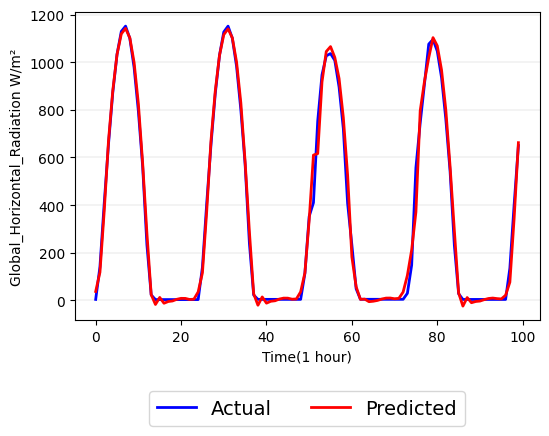

In [ ]:
n_samples = 100

plt.figure(figsize=(6, 4))
plt.plot(y_test_inv[:n_samples], label='Actual', linewidth=2, color='blue')
plt.plot(pred_test[:n_samples], label='Predicted', linewidth=2, color='red')
plt.ylabel('Global_Horizontal_Radiation W/m²',)
plt.xlabel('Time(1 hour)')
plt.legend(fontsize=14)
plt.legend(fontsize=14, bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=2)
# Add a horizontal grid
plt.grid(axis='y',linewidth=0.2)
plt.savefig('/content/GRU-EO.png')
